# Classifying dog breeds

We here wish to tackle the dog breeds classification problem. We will specifically focus on two objectives:

1. Make a lean and lightweight classifier that still manages above 60% accuracy.
2. Explore pruning and weighting filters outputed by pre-trained Convolutional Neural Networks architectures amenable to transfer learning.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as pl
%matplotlib inline
import seaborn as sb
sb.set(font_scale=1.4, style='ticks')

from utils.data import DogBreedData
from utils.model import AttentiveModel

## Loading the data for exploration

It should be noted that `DogBreedData` once intialize will look in the git root for a data directory containing images and pre-calculated features. Images and annotations will be downloaded from [http://vision.stanford.edu/aditya86/ImageNetDogs/](http://vision.stanford.edu/aditya86/ImageNetDogs/) if required and image features will be calculated using a pre-trained [SqueezeNet](https://github.com/rcmalli/keras-squeezenet) if not already done. The latter architecture was chosen for it's small footprint and high accuracy on the ImageNet task ([https://arxiv.org/pdf/1602.07360.pdf](https://arxiv.org/pdf/1602.07360.pdf)) such that it is feasible to quickly explore and iterate on a local machine.

The SqueezeNet implementation in Keras outputs, without the classifier head, a 13x13x512 feature tensor from the so-called 9th *Fire* unit. It is debatable whether this is the optimal layer to work with for transfer learning. But the goal not being to reach state-of-the-art accuracy, we will not explore other options.

Each feature tensor was pre-calculated for all dog images, reshaped to 169x512, and stored in a HDF5 file handled by `DogBreedData`.

In [4]:
# Data handling class
dbd = DogBreedData(use_annotations=True, kmodel='SqueezeNet', im_size=227, batch_size=256)

In [5]:
# Handles on the features and targets contained in a HDF5 file (uncompressed)
features = dbd.fh['features']
targets = dbd.fh['targets']
n = features.shape[0]

## Exploring filter activation

The SqueezeNet model used to calculate the image features was initially trained on the ImageNet dataset that comprises images accross a 1000 categories. Amongst those, funnily enough we have multiple dog breeds. Nevertheless, we're interested in the general concept of transfer learning towards classifying specifically the dog breeds.

Here we take a look at the (mean) activation of the 512 filters to try and see if we can select those more relevant to dogs. Let us focus our attention on those filters whose activation is on average stronger and whose variability accross images is greater.

In [6]:
# The mean activation for all filters accross all images
mean_act = np.array([x.mean(axis=0) for x in features])

In [7]:
# Standard deviation of mean activation and average of the mean
# for all filters
X_std_act = mean_act.std(axis=0)
X_avg_act = mean_act.mean(axis=0)

In [8]:
# Let us consider values greater than a given threshold
mask_std = X_std_act > 2*X_std_act.std()
mask_avg = X_avg_act > 2*X_avg_act.std()

In [9]:
# We combine both masks
mask = mask_std & mask_avg
print('{} filters will be considered'.format(mask.sum()))

149 filters will be considered


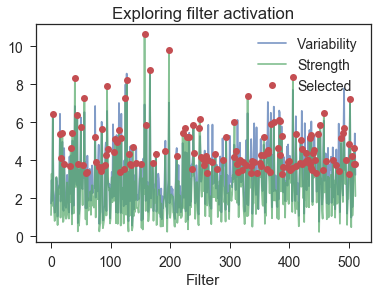

In [10]:
fig, ax = pl.subplots()
ax.plot(X_std_act, label='Variability', alpha=0.7)
ax.plot(X_avg_act, label='Strength', alpha=0.7)
ax.plot(np.where(mask)[0], X_avg_act[mask], 'o', label='Selected')
ax.set_xlabel('Filter')
ax.set_title('Exploring filter activation')
ax.legend(loc='best')

For the model below, we will use only that subset of filters whose average activation is strong and whose variability is indicative of discrimination power.

## Can attention help?

Let us build a simple model to classify dog breeds based on the features extracted from SqueezeNet further reduced by using the subset of "significant" filters identified above. We will further test the hypothesis that certain filters have, on average, a stronger association with certain dog breeds by introducing filter based attention in our small classifier. This classifier is really quite simple in structure:

![Classifier](figures/classifier.svg)

The attention mechanism was inspired by [https://arxiv.org/abs/1512.08756](https://arxiv.org/abs/1512.08756) and modfied from [Baziotis' Gist entry](https://gist.github.com/cbaziotis/6428df359af27d58078ca5ed9792bd6d). It essentially learns the importance of the filters and weighs them appropriately. It should be know that this simple attention scheme adds only 318 parameters to ~400K initially present.

In [33]:
# The attentive network
m = AttentiveModel(dbd, mask=mask)

In [34]:
# Filter attention: is it any useful
hist = {}
basename = 'dog_breeds_model'
for a,a_func in zip([True, False],['Attention','No_Attention']):
    m.clear_session()
    m.build(attention=a, attention_func=a_func)
    m.compile(lr=0.01)
    h = m.train(epochs=40, save_path="{}.{}.h5".format(basename, a_func))
    hist[a_func] = h

Epoch 1/40
1221/1221 [==============================] - 26s 22ms/step - loss: 2.6238 - acc: 0.3399 - val_loss: 1.6806 - val_acc: 0.5273

Epoch 00001: val_loss improved from inf to 1.68058, saving model to dog_breeds_model.Attention.h5
Epoch 2/40
1221/1221 [==============================] - 26s 21ms/step - loss: 1.6413 - acc: 0.5241 - val_loss: 1.4642 - val_acc: 0.5645

Epoch 00002: val_loss improved from 1.68058 to 1.46417, saving model to dog_breeds_model.Attention.h5
Epoch 3/40
1221/1221 [==============================] - 27s 22ms/step - loss: 1.4771 - acc: 0.5684 - val_loss: 1.3644 - val_acc: 0.5928

Epoch 00003: val_loss improved from 1.46417 to 1.36445, saving model to dog_breeds_model.Attention.h5
Epoch 4/40
1221/1221 [==============================] - 26s 22ms/step - loss: 1.3825 - acc: 0.5926 - val_loss: 1.3131 - val_acc: 0.6133

Epoch 00004: val_loss improved from 1.36445 to 1.31311, saving model to dog_breeds_model.Attention.h5
Epoch 5/40
1221/1221 [==========================

1221/1221 [==============================] - 16s 14ms/step - loss: 0.9291 - acc: 0.7133 - val_loss: 1.1545 - val_acc: 0.6602

Epoch 00033: val_loss did not improve
Epoch 34/40
1221/1221 [==============================] - 16s 13ms/step - loss: 0.9191 - acc: 0.7159 - val_loss: 1.1593 - val_acc: 0.6582

Epoch 00034: val_loss did not improve
Epoch 35/40
1221/1221 [==============================] - 16s 13ms/step - loss: 0.9118 - acc: 0.7203 - val_loss: 1.1373 - val_acc: 0.6670

Epoch 00035: val_loss improved from 1.15249 to 1.13727, saving model to dog_breeds_model.No_Attention.h5
Epoch 36/40
1221/1221 [==============================] - 15s 13ms/step - loss: 0.9029 - acc: 0.7224 - val_loss: 1.1456 - val_acc: 0.6592

Epoch 00036: val_loss did not improve
Epoch 37/40
1221/1221 [==============================] - 15s 12ms/step - loss: 0.8912 - acc: 0.7217 - val_loss: 1.1524 - val_acc: 0.6592

Epoch 00037: val_loss did not improve
Epoch 38/40
1221/1221 [==============================] - 16s 13ms

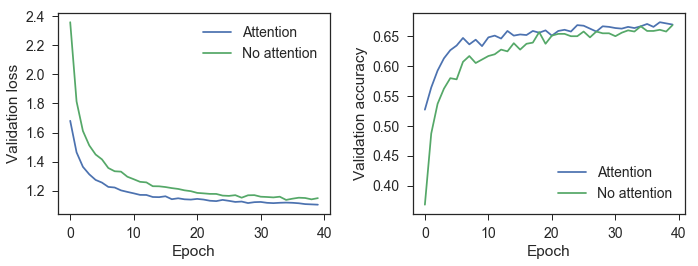

In [42]:
fig,ax = pl.subplots(nrows=1,ncols=2,figsize=(10,4))
ax[0].plot(hist['Attention'].history['val_loss'], label='Attention')
ax[0].plot(hist['No_Attention'].history['val_loss'], label='No attention')
ax[0].legend(loc='best')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Validation loss')

ax[1].plot(hist['Attention'].history['val_acc'], label='Attention')
ax[1].plot(hist['No_Attention'].history['val_acc'], label='No attention')
ax[1].legend(loc='best')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation accuracy')

pl.tight_layout()

As can be seen in the plot above, introducing attention appears to significantly speed-up convergence while marginally improving the loss (and potentially accuracy). Compared to the countless examples of dog classifiers that can be found online (it was a Kaggle challenge after all!), this accuracy might appear disappointing. But with respect to our two initial objectives we have shown that:

1. A fast and relatively lightweight pipeline can be constructed to classify dog breeds with approximately 66% accuracy.
2. The above can be achieved by pruning at least 70% of filters and using trainable attention to weigh the remaining filters.

# Checking the top N

For many applications, the top N accuracy, where N stays relatively modest, might be more relevant than the top 1. Here we report on such a value up to N=10. The good news is that considering only the top 4 already puts us above 90% accuracy.

In [48]:
# Need to reproduce the train, valid split that was used 
# for training the model, hence the random_state=0
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=0)
for train_idx, test_idx in sss.split(targets[:], targets[:]): pass

In [50]:
# Get the validation set
idx = list(np.sort(test_idx))
X_valid = features[idx,:,:][:,:,mask]
Y_valid = targets[idx]

In [51]:
# Load the previously trained attentive model
m = AttentiveModel(dbd, mask=mask)
m.clear_session()
m.build(attention=True, attention_func='Attention')
m.load('dog_breeds_model.Attention.h5')

In [52]:
Y_pred = m.model.predict(X_valid)
idx_top = Y_pred.argsort(axis=1)[:,::-1]

In [58]:
acc_topn = np.cumsum(idx_top == np.expand_dims(Y_valid, axis=1),axis=1).mean(axis=0)

Text(0,0.5,'Accuracy')

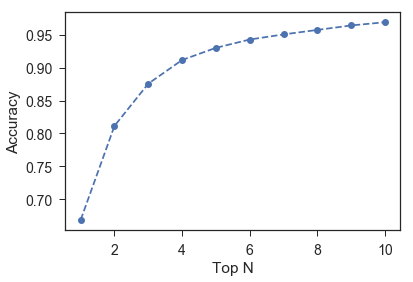

In [62]:
fig,ax = pl.subplots()
ax.plot(np.arange(10)+1, acc_topn[:10], '--o')
ax.set_xlabel('Top N')
ax.set_ylabel('Accuracy')